In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv(override=True)

from pydantic import BaseModel, Field

import nest_asyncio
nest_asyncio.apply()
from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo
from typing import List, Dict
import re
import plotreader
from plotreader.utils.document import ScientificPaperHandler
from plotreader.utils.base import BasicAnthropicLLM

In [3]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [4]:
all_nodes = handler.load_docs()

In [7]:
all_nodes

[TextNode(id_='2489352a-7c62-4272-8a19-0746ceb0f845', embedding=None, metadata={'Header_1': 'Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics', 'experimental_variable_entities': ['channelrhodopsin', 'optogenetics'], 'fig_refs': []}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='c2155598-52f8-4e4f-9b94-62149747c0b0', node_type=None, metadata={}, hash=None)}, text='Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics\n\nClaire N. Bedbrook<sup>1</sup>, Kevin K. Yang<sup>2,†</sup>, J. Elliott Robinson<sup>1,†</sup>, Elisha D. Mackey<sup>1</sup>, Viviana Gradinaru<sup>1,*</sup>, Frances H. Arnold<sup>1,2,*<

In [5]:
fig_num = 3

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value=f'Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

query_tool = handler.query_engine_tool(top_k=10, metadata_filters=filters)

In [6]:
class Variable(BaseModel):
    name: str
    categorical: bool

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    # statistics: List[str]



In [7]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [8]:
response = query_tool(prompt)

In [9]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='6d1ee3b6-ef3e-45ae

In [10]:
figure_struct = output_parser.parse(response.content)

In [11]:
fig_description = f"{figure_struct.name}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name}"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 3
	Panel: b

		Plot: Microscope images
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Neuron morphology', categorical=False)]
	Panel: c

		Plot: Photocurrent bar graphs
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Light intensity', categorical=True)] dependent_variables=[Variable(name='Photocurrent', categorical=False)]
	Panel: d

		Plot: Spike fidelity vs Light intensity
			independent_variables=[Variable(name='Light intensity', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: e

		Plot: Spike fidelity vs Frequency
			independent_variables=[Variable(name='Frequency', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: f

		Plot: Voltage traces
			independent_variables=[Variable(n

In [44]:
from typing import Union

In [45]:
panel = figure_struct.panels[2]
plot = panel.plots[0]
exp = plot.experiments[0]

class CategoricalVariable(BaseModel):
    name: str
    label_type: str = Field(
        ...,
        description="What type of visual signifier is used to label this class in the plot (e.g. color, markertype, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable. If the label is color, give the RGB value as a list of float."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting categorical labels from plots in scientific papers.
    You will always primarily look to the image of the figure.
    If the information is not available in the image, you can look to the text.
    You will always dummy check your answer by counting the number of expected labels in the image.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
        In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
    Return your answer as structured data.
        """
        
    else:
        var_cls = NumericVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given an numeric independent variable and a plot containing datapoints corresponding to that variable.
    Your job is to give the set of values for that variable for the markers in the the specific plot (not the whole figure). 
    You will always dummy check your answer by counting the number of expected datapoints in the plot.

    YOUR CURRENT TASK:

In Figure {fig_num}{panel.name}, plot title/description: {plot.name}, what set are the values of {iv.name} plotted across all data in the panel?
    IMPORTANT: 
        WE WANT TO MATCH THE FIGURE. USE THE TEXT TO HELP, BUT IF THERE IS A DISCREPANCY, RESOLVE ASSUMING THE IMAGE IS CORRECT.
        COUNT THE NUMBER OF POINTS OR LINES IN THE IMAGE TO ENSURE THAT YOU RETURN THE CORRECT NUMBER OF VALUES.
        THAT IS, DO NOT REPORT THE LOCATIONS OF AXIS TICKE MARKS OR TICK MARK LABELS, REPORT THE VALUES OF THE POINTS ON THE PLOT!!!
    Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    # response = query_tool(prompt)
    # text = response.content

    response = query_tool(prompt)
    text = response.content

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Light intensity' categorical=False
name='ChR variant' categorical=True


In [46]:
ivs_with_values

[NumericVariable(name='Light intensity', values=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0], unit='mW mm^-2'),
 CategoricalVariable(name='ChR variant', label_type='color', values={'ChRger1': [255.0, 192.0, 203.0], 'ChRger2': [0.0, 255.0, 255.0], 'ChRger3': [0.0, 255.0, 0.0], 'CoChR': [128.0, 128.0, 128.0], 'ChR2': [0.0, 0.0, 0.0]})]

In [14]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='6d1ee3b6-ef3e-45ae

In [15]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [16]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given a numeric dedependent variable and a plot containing data points which have values for that variable.
    Your job is to give values for the markers in the plot as a function of the provided independent variables.
    We want to match the data points in the plot EXACTLY - not just the shapes or trends.
    You will always dummy check your answer by counting the number of expected datapoints, lines, etc in the plot.
    When there is a discrepency between text and graphic, align your answer to the graphic.

In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?
Get the value for each condition. To help, here is our current belief on the independent variables and their values for this plot:
{ind_vars}

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = query_tool(prompt)
panel_df = output_parser.parse(data_response.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [17]:
data_response.raw_output.source_nodes

[NodeWithScore(node=ImageNode(id_='ddbd3ffb-d1c1-4a05-9c3a-180685f3910b', embedding=None, metadata={'page_number': 24, 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='79966a73-edea-46f3-b47f-81295e5616cb', node_type=None, metadata={}, hash=None)}, text='The graphic compares the performance of ChRger variants with commonly used ChR2 (H134R) and CoChR in cultured neurons and acute brain slices. It includes data on photocurrent strength, spike fidelity, and light intensity response.\n\na) ChRs were cloned into an AAV vector with either the hSyn or CamKIIa promoter and packaged into rAAV-PHP.eB for expression in culture and in vivo.\n\nb) Cultured neurons expressing ChRgers and ChR2 (H134R) under the hSyn promoter. Images show neurons with ChR2, ChRger1, ChRger2, and ChRger3. Scale bars are 10 μm.\n\nc) Peak and steady-state photocurrent with low-intensity (8x10^-3 mW mm^-2) a

In [18]:


# def get_color(color_name):
#     try:
#         return mcolors.to_rgba(color_name)
#     except ValueError:
#         # If the color name is not recognized, you can provide a fallback
#         return mcolors.to_rgba('gray')
    



In [19]:
import seaborn as sns

[]

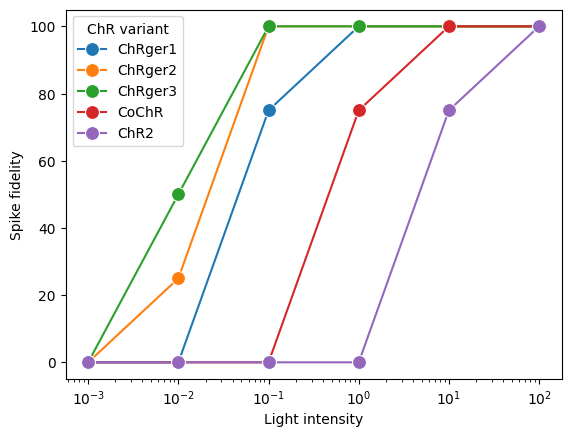

In [47]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

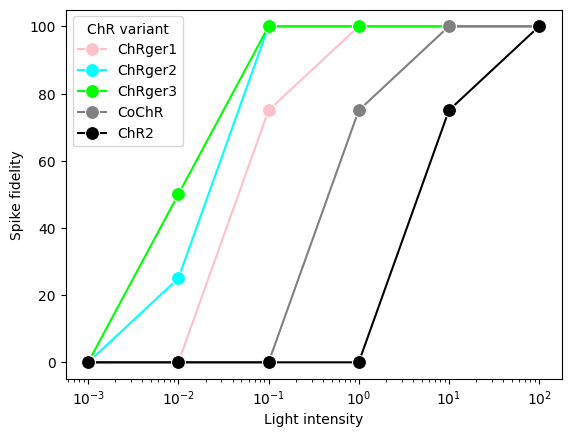

In [51]:
chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items()]
palette = [np.array(v)/255. for k,v in chr_variant_iv.values.items()]

axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
axes.set_xscale('log')

In [327]:
from PIL import Image

# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img = Image.open('plot.png')

In [328]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO

from plotreader.utils.base import BasicAnthropicLLM

claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")

for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response = claude_mm.message(prompt, images = [source_figure, generated_img])

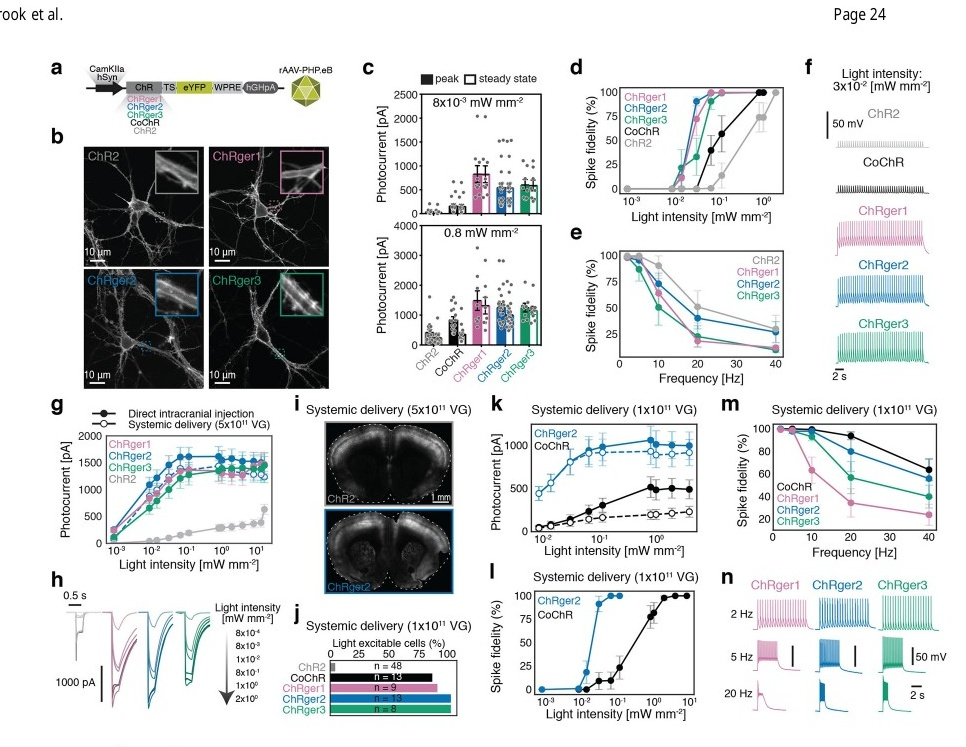

In [329]:
source_figure

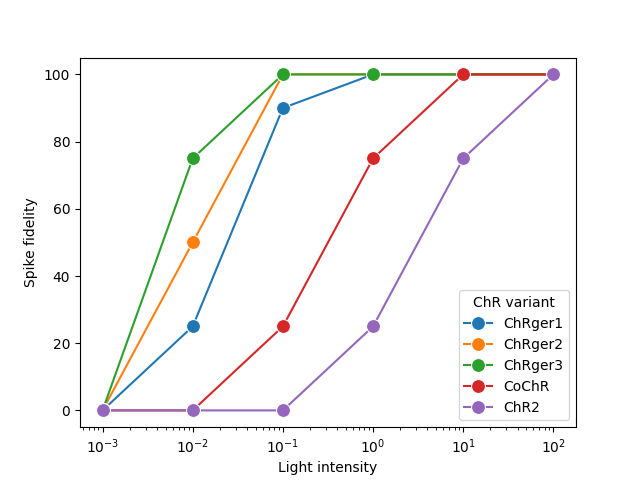

In [330]:
generated_img

In [331]:
print(response.content[0].text)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1, ChRger2, and ChRger3: In the source figure, these curves appear to be smoother and more sigmoidal, especially between 0.01 and 0.1 mW/mm². In the re-plotted data, these curves are more angular and abrupt. For example, ChRger3 in the re-plot jumps from 75% to 100% spike fidelity between 0.01 and 0.1 mW/mm², while in the original, it appears to have a more gradual increase.

2. CoChR performance at low light intensities: In the source figure, CoChR shows some activity (around 25% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm² and only starts showing activity (25%) at 0.1 mW/mm².

3. ChR2 performance at higher light intensities: In the source figure, ChR2 appears to reach close to 100% spike fidelity at 100 mW/mm². In the re-plotted data, ChR2 reaches exactly 100% at this intensity

In [332]:
feedback = response.content[0].text

In [351]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

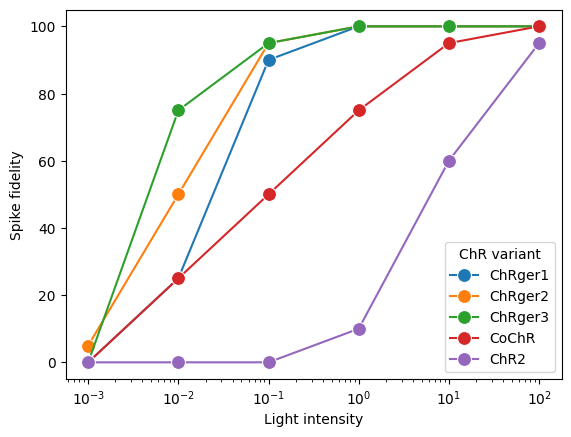

In [352]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [345]:
# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img_rev = Image.open('plot.png')

In [346]:


claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")


prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response_2 = claude_mm.message(prompt, images = [source_figure, generated_img_rev])

In [347]:
feedback_2 = response_2.content[0].text
print(feedback_2)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1: In the source figure, the ChRger1 curve (pink) shows a more gradual increase in spike fidelity between 0.01 and 0.1 mW/mm². However, in the re-plotted data, there's a sharp jump from 25% at 0.01 mW/mm² to 95% at 0.1 mW/mm². This difference significantly alters the shape of the curve for ChRger1 in the low light intensity range.

2. CoChR performance at low intensities: In the source figure, the CoChR curve (black) shows some activity (around 20-30% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm². This difference affects the interpretation of CoChR's sensitivity at low light intensities.

3. ChR2 curve shift: In the source figure, the ChR2 curve (gray) begins to rise noticeably around 1 mW/mm² and reaches about 50% spike fidelity at 10 mW/mm². In the re-plotted data, the ChR2 curv

In [364]:
panel_df

Light intensity ChR variant Spike fidelity
0             0.001     ChRger1              0
1             0.010     ChRger1              0
2             0.100     ChRger1             75
3             1.000     ChRger1            100
4            10.000     ChRger1            100
5           100.000     ChRger1            100
6             0.001     ChRger2              0
7             0.010     ChRger2             25
8             0.100     ChRger2            100
9             1.000     ChRger2            100
10           10.000     ChRger2            100
11          100.000     ChRger2            100
12            0.001     ChRger3              0
13            0.010     ChRger3             50
14            0.100     ChRger3            100
15            1.000     ChRger3            100
16           10.000     ChRger3            100
17          100.000     ChRger3            100
18            0.001       CoChR              0
19            0.010       CoChR              0
20            0.100       CoChR              0
21            1.000       CoChR             50
22           10.000       CoChR            100
23          100.000       CoChR            100
24            0.001        ChR2              0
25            0.010        ChR2              0
26            0.100        ChR2              0
27            1.000        ChR2              0
28           10.000        ChR2             75
29          100.000        ChR2            100

In [348]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback_2,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

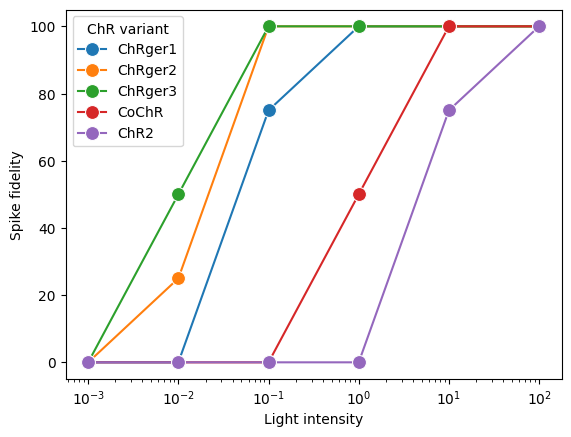

In [28]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [24]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO
from PIL import Image


In [25]:
for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

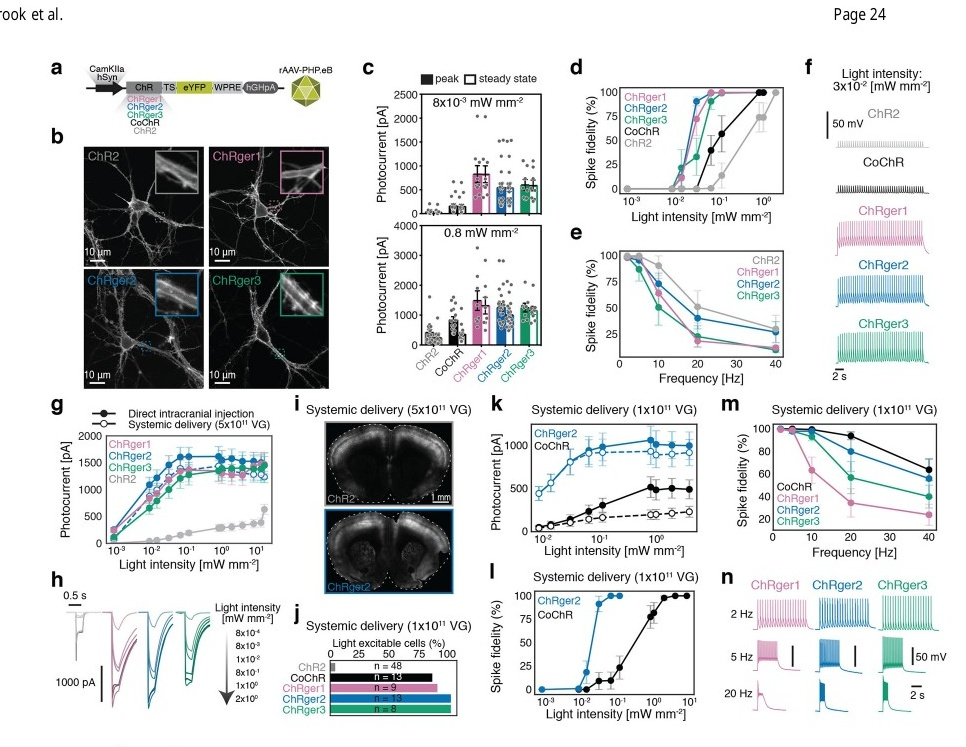

In [26]:
source_figure

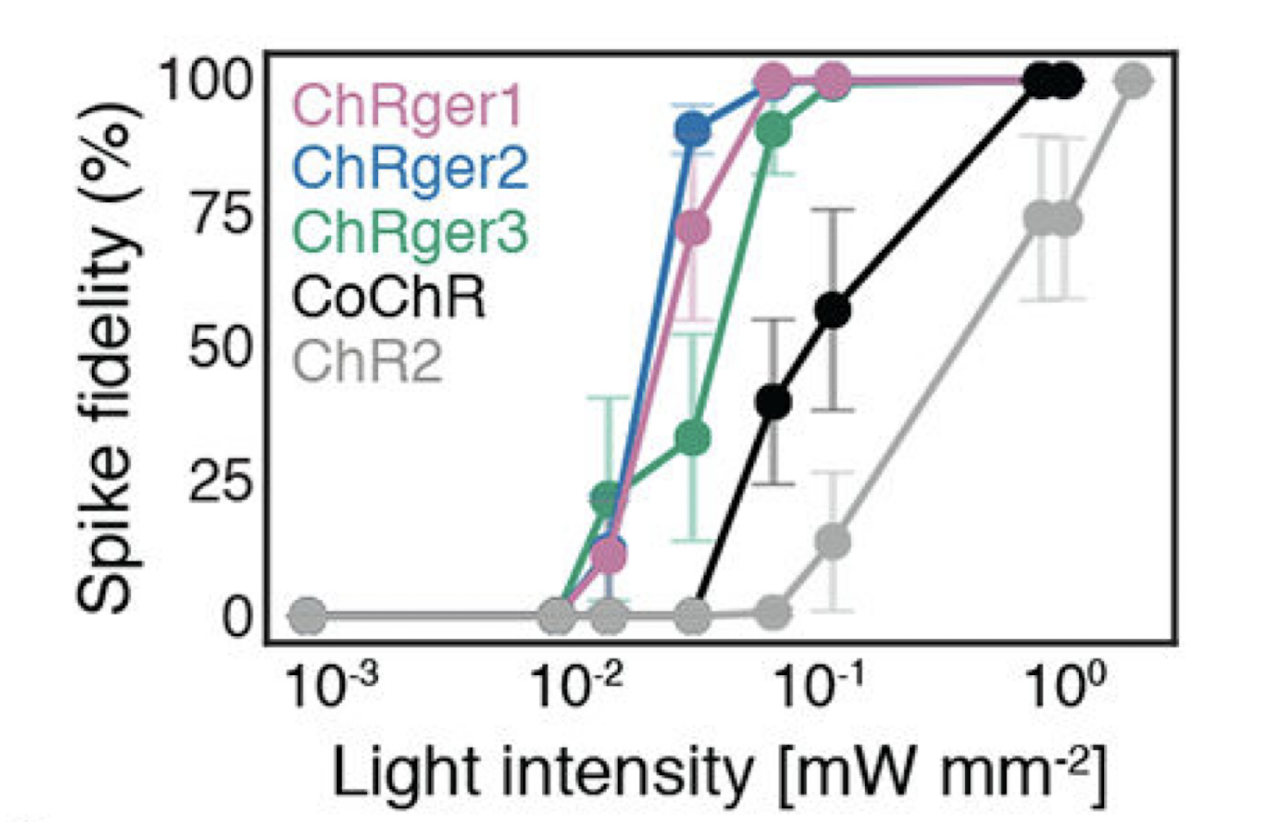

In [27]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
source_image = Image.open(source_panel)
source_image

In [54]:
import numpy as np

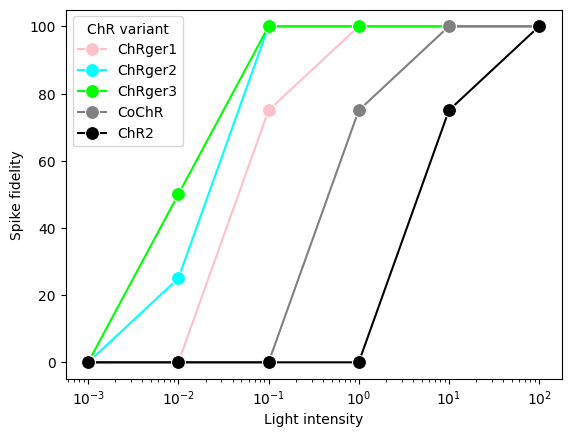

In [55]:
chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items()]
palette = [np.array(v)/255. for k,v in chr_variant_iv.values.items()]

axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
axes.set_xscale('log')

After comparing the recreated plot with the source figure, here are the three largest quantitative differences I observe:

1. Curve shape for ChRger1, ChRger2, and ChRger3: In the source figure, these curves have a more gradual, sigmoidal shape. In the recreated plot, they appear more step-like with sharp transitions. For example, ChRger1 jumps from 0% to 75% spike fidelity between 0.01 and 0.1 mW/mm² in the recreated plot, while the original shows a more gradual increase.

2. CoChR curve position: In the recreated plot, the CoChR curve is shifted to the right compared to the original. In the source figure, CoChR reaches about 50% spike fidelity at around 0.1 mW/mm², while in the recreated plot, it's still at 0% at this light intensity and only reaches 75% at 1 mW/mm².

3. ChR2 sensitivity: The recreated plot shows ChR2 as less sensitive than in the original figure. In the source figure, ChR2 starts to show some activity (>0% spike fidelity) at around 1 mW/mm², while in the recreated p

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), I can identify three major quantitative differences:

1. Shift in CoChR curve: In the original figure, the CoChR curve (gray) starts to rise at a lower light intensity compared to the re-plotted data. In the original, it begins to increase around 0.01 mW/mm², reaching about 25% spike fidelity. However, in the re-plotted data, it remains at 0% at 0.01 mW/mm² and only starts rising at 0.1 mW/mm².

2. ChRger1 curve shape: The ChRger1 curve (pink) in the original figure has a more gradual slope, especially between 0.01 and 0.1 mW/mm². In the original, it reaches about 50% spike fidelity at 0.01 mW/mm² and about 75% at 0.1 mW/mm². In contrast, the re-plotted data shows a steeper increase, with 25% at 0.01 mW/mm² and 90% at 0.1 mW/mm².

3. ChR2 maximum spike fidelity: In the original figure, the ChR2 curve (black) reaches 100% spike fidelity at 100 mW/mm². However, in the re-plotted data, it only reaches about 80% at 10 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), I've identified the following three largest quantitative differences:

1. ChRger1 curve shape: In the source figure, the ChRger1 curve (pink) rises more steeply between 10^-3 and 10^-2 mW/mm^2, reaching about 75% spike fidelity at 10^-2 mW/mm^2. In the re-plotted data, this rise is less steep, only reaching 50% spike fidelity at 10^-2 mW/mm^2.

2. ChRger2 maximum spike fidelity: In the source figure, ChRger2 (light blue) reaches 100% spike fidelity at around 10^-1 mW/mm^2 and maintains it for higher intensities. In the re-plotted data, ChRger2 only reaches 95% spike fidelity at 10^-1 mW/mm^2, not achieving 100% until 1 mW/mm^2.

3. CoChR curve shape: The CoChR curve (gray) in the source figure shows a more gradual increase in spike fidelity, reaching about 90% at 1 mW/mm^2 and 100% at 10 mW/mm^2. In the re-plotted data, the curve is steeper, reaching 95% at 1 mW/mm^2 and 100% at 10 mW/mm^2.

These differences affec

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), I've identified the following three largest quantitative differences:

1. CoChR curve shape: In the source figure, the CoChR curve (gray) shows a more gradual increase in spike fidelity from 0.01 to 10 mW/mm². However, in the re-plotted data, the CoChR curve shows a steeper increase, reaching 90% spike fidelity at 1 mW/mm² and 100% at 10 mW/mm². This difference affects multiple datapoints along the CoChR curve.

2. ChRger2 initial response: In the source figure, ChRger2 (light blue) shows some activity (around 25% spike fidelity) at 0.001 mW/mm². In the re-plotted data, ChRger2 starts at 0% spike fidelity at 0.001 mW/mm². This shifts the entire curve slightly to the right compared to the original.

3. ChR2 high-intensity response: In the source figure, ChR2 (black) reaches 100% spike fidelity at a lower light intensity, around 10-30 mW/mm². In the re-plotted data, ChR2 only reaches 80% at 10 mW/mm² and doesn't hit 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, I can identify three major quantitative differences:

1. ChRger2 low-intensity response: In the re-plotted data, ChRger2 (light blue line) shows a spike fidelity of 25% at the lowest light intensity (0.001 mW/mm²). However, in the source figure, ChRger2's curve starts much closer to 0% at this intensity. This is a significant difference of about 25 percentage points at the lowest light intensity.

2. CoChR mid-range response: The re-plotted data shows CoChR (gray line) with a spike fidelity of 60% at 1 mW/mm² light intensity. In the source figure, CoChR's curve appears to reach about 75-80% at this intensity. This represents a difference of approximately 15-20 percentage points in the middle of the curve.

3. ChR2 high-intensity response: In the re-plotted data, ChR2 (black line) reaches 95% spike fidelity at 10 mW/mm² and 100% at 100 mW/mm². The source figure shows ChR2 reaching only about 80-85% at the highest intensities, n

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, I've identified the following three largest quantitative differences:

1. CoChR curve shape: In the source figure, the CoChR curve (gray) shows a more gradual increase in spike fidelity from 0.001 to 1 mW/mm². However, in the re-plotted data, the CoChR curve shows a steeper increase, particularly between 0.01 and 1 mW/mm². For example, at 0.1 mW/mm², the spike fidelity in the source figure appears to be around 50%, while in the re-plotted data it's only 25%.

2. ChR2 maximum spike fidelity: In the source figure, the ChR2 curve (black) reaches a maximum spike fidelity of about 95-100% at 100 mW/mm². However, in the re-plotted data, the maximum spike fidelity for ChR2 is only 85% at 100 mW/mm².

3. ChRger1, ChRger2, and ChRger3 low-intensity behavior: In the source figure, these three variants (pink, light blue, and green) show slight differences in their responses at low light intensities (0.001 to 0.01 mW/mm²). However, in the

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, I can identify three major quantitative differences:

1. CoChR curve shape: In the source figure, the CoChR curve (gray) shows a more gradual increase in spike fidelity across light intensities. However, in the re-plotted data, the CoChR curve shows a steeper increase, particularly between 0.01 and 1 mW/mm². For example, at 0.1 mW/mm², the source figure shows a spike fidelity of about 75% for CoChR, while our data shows only 50%.

2. ChR2 activation threshold: In the source figure, ChR2 (black line) starts showing activity (non-zero spike fidelity) at around 0.1 mW/mm². However, in our re-plotted data, ChR2 remains at 0% spike fidelity until 1 mW/mm². This shifts the entire ChR2 curve to the right in our plot compared to the original.

3. ChRger variants at low intensities: In the source figure, the ChRger1, ChRger2, and ChRger3 variants (pink, light blue, and green lines) show very little activity at 0.001 mW/mm², with spike 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, I can identify three major quantitative differences:

1. CoChR curve shape: In the source figure, the CoChR curve (gray) rises more gradually and reaches 100% spike fidelity at a higher light intensity. In the re-plotted data, the CoChR curve rises more steeply and plateaus at 98% spike fidelity. This affects multiple data points along the curve, particularly in the 0.1 to 10 mW/mm² range.

2. ChR2 low-intensity response: In the source figure, the ChR2 curve (black) shows some response (around 10-20% spike fidelity) at 0.1 mW/mm². In the re-plotted data, the ChR2 response at 0.1 mW/mm² is only 5%. This difference affects the initial rise of the ChR2 curve.

3. ChRger variants' saturation point: In the source figure, the ChRger1, ChRger2, and ChRger3 curves (pink, light blue, and green) reach 100% spike fidelity at around 0.1 mW/mm². In the re-plotted data, ChRger1 doesn't reach 100% until 1 mW/mm². This shifts the saturation p

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, I've identified the following three largest quantitative differences:

1. ChRger1 curve shape: In the source figure, ChRger1 (pink line) shows a steeper rise between 10^-3 and 10^-2 light intensity, reaching about 50% spike fidelity at 10^-2. In the re-plotted data, ChRger1 jumps from 0% at 10^-3 to 85% at 10^-2, which is a much sharper increase and higher value at 10^-2.

2. CoChR curve values: The re-plotted data for CoChR (gray line) shows consistently lower spike fidelity values compared to the source figure. For example, at 10^-1 light intensity, the re-plotted data shows about 40% spike fidelity, while the source figure shows closer to 60-65%.

3. ChR2 maximum value: In the source figure, the ChR2 curve (black line) appears to reach 100% spike fidelity at the highest light intensity (10^2). However, in the re-plotted data, the maximum value for ChR2 is 98% at 10^2 light intensity.

These differences affect multiple data 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, I've identified the following three largest quantitative differences:

1. CoChR curve shape: In the source figure, the CoChR curve shows a more gradual increase in spike fidelity from 0.1 to 10 mW/mm². However, in the re-plotted data, there's a steeper increase between these points. Specifically, in the re-plot, the spike fidelity jumps from 65% at 0.1 mW/mm² to 90% at 1 mW/mm², whereas the original figure shows a more gradual rise.

2. ChR2 low-intensity response: In the source figure, ChR2 shows some response (about 5-10% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, ChR2 shows 0% spike fidelity at this light intensity. This affects the overall shape of the ChR2 curve at lower intensities.

3. ChRger variants at low intensities: In the source figure, the ChRger1, ChRger2, and ChRger3 variants show slight differences in their responses at 0.01 mW/mm². However, in the re-plotted data, these differences are m

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), I've identified the following three largest quantitative differences:

1. Spike fidelity values for ChRger1, ChRger2, and ChRger3 at 0.01 mW/mm² light intensity:
   In the source figure, these values appear to be around 30-40%, while in the re-plotted data, they are significantly higher at 55%, 65%, and 60% respectively. This is a difference of about 20-30 percentage points.

2. CoChR curve shape and values:
   In the source figure, the CoChR curve shows a more gradual increase, with non-zero values starting from around 0.01 mW/mm². In the re-plotted data, the curve starts at 0% for both 0.001 and 0.01 mW/mm², then jumps to 40% at 0.1 mW/mm². This creates a steeper initial increase and alters the overall shape of the curve.

3. ChR2 values at lower light intensities:
   In the source figure, the ChR2 curve shows very low but non-zero values at light intensities below 0.1 mW/mm². In the re-plotted data, the value at

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, I can identify three major quantitative differences:

1. ChRger variants (ChRger1, ChRger2, ChRger3) performance at low light intensities:
In the source figure, these variants show some differences in their performance at light intensities between 10^-3 and 10^-2 mW mm^-2. However, in the re-plotted data, their performance is nearly identical, with all three variants showing 0% spike fidelity at 10^-3 mW mm^-2 and around 35-40% at 10^-2 mW mm^-2. This simplification in the re-plotted data doesn't capture the subtle differences visible in the original figure.

2. CoChR performance curve:
The re-plotted data for CoChR shows a more linear increase in spike fidelity from 0.01 to 10 mW mm^-2, while the original figure displays a more curved, sigmoidal shape. Specifically, at 0.1 mW mm^-2, the re-plotted data shows about 25% spike fidelity, whereas the original figure appears to show closer to 50%.

3. ChR2 performance at medium lig

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, I can identify three major quantitative differences:

1. CoChR curve shift: In the source figure, the CoChR curve (gray) shows non-zero spike fidelity at lower light intensities. However, in the re-plotted data, the CoChR curve starts at 0% spike fidelity for both 0.001 and 0.01 mW/mm² light intensities. This shifts the entire curve to the right compared to the original figure.

2. ChR2 curve shape: The ChR2 curve (black) in the re-plotted data shows a more abrupt increase in spike fidelity compared to the source figure. In the original, the curve rises more gradually, whereas in the re-plot, it jumps from 0% at 0.1 mW/mm² to 50% at 1 mW/mm², creating a steeper slope.

3. ChRger variants at low intensities: In the source figure, the ChRger1, ChRger2, and ChRger3 variants (pink, light blue, and green, respectively) show some separation at very low light intensities (around 0.001-0.01 mW/mm²). However, in the re-plotted data, th

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three largest quantitative differences I've identified:

1. CoChR curve shape: In the source figure, the CoChR curve (gray) shows a more gradual increase in spike fidelity from 0.1 to 10 mW/mm². However, in the re-plotted data, there's a steeper jump from 60% at 0.1 mW/mm² to 95% at 1 mW/mm². This affects multiple datapoints and changes the overall shape of the CoChR curve.

2. ChRger1 initial value: In the source figure, ChRger1 (pink) starts at around 20-25% spike fidelity at 0.001 mW/mm². However, in the re-plotted data, it starts at only 5% for the same light intensity. This is a significant difference of about 15-20 percentage points for the lowest light intensity datapoint.

3. ChR2 mid-range values: In the source figure, the ChR2 curve (black) shows lower spike fidelity values in the mid-range of light intensities compared to the re-plotted data. Specifically, at 1 mW/mm², the source figure shows a spike fi

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, I can identify three major quantitative differences:

1. CoChR curve shape: In the source figure, the CoChR curve (gray) shows a more gradual increase in spike fidelity across light intensities. However, in the re-plotted data, the CoChR curve shows a steeper increase, particularly between 0.01 and 1 mW/mm². For example, at 0.1 mW/mm², the spike fidelity in the re-plotted data is about 60%, while in the source figure it appears to be closer to 40%.

2. ChRger1 initial point: In the re-plotted data, ChRger1 (pink) starts at a spike fidelity of 25% at 0.001 mW/mm². However, in the source figure, this initial point appears to be lower, closer to 10-15% spike fidelity.

3. ChR2 curve shift: The ChR2 curve (black) in the re-plotted data is shifted slightly to the right compared to the source figure. This is most noticeable at higher light intensities. For instance, at 10 mW/mm², the re-plotted data shows a spike fidelity of about 6

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the recreated plot with the source figure (Fig. 3d), I can identify three major quantitative differences:

1. CoChR curve shift: In the original figure, the CoChR curve (gray) is positioned further to the left, indicating higher sensitivity at lower light intensities. For example, at 0.1 mW/mm², the original shows a spike fidelity of about 60-65%, while our recreated plot shows only 40%.

2. ChR2 curve shape: The ChR2 curve (black) in the original figure has a more gradual slope, especially between 1 and 10 mW/mm². In the original, the spike fidelity at 1 mW/mm² is around 10-15%, increasing to about 50-55% at 10 mW/mm². Our recreated plot shows a steeper increase from 25% to 80% over the same range.

3. ChRger variants' low-intensity responses: In the original figure, the ChRger1, ChRger2, and ChRger3 variants (pink, light blue, and green, respectively) show lower spike fidelity at 0.001 mW/mm² compared to our recreated plot. For instance, ChRger1 and ChRger2 appear to 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure (Figure 3d), I've identified the following three largest quantitative differences:

1. ChR2 curve shift: In the source figure, the ChR2 curve (black) starts to rise at a lower light intensity compared to the re-plotted data. Specifically, in the original, ChR2 shows some activity around 10^-1 mW mm^-2, while in the re-plotted data, it only starts rising at 1 mW mm^-2. This shifts the entire ChR2 curve to the right in the re-plotted version.

2. CoChR curve shape: The CoChR curve (gray) in the re-plotted data appears more linear and less sigmoidal compared to the source figure. In the original, there's a steeper rise between 10^-2 and 10^-1 mW mm^-2, followed by a more gradual increase. The re-plotted data shows a more constant rate of increase across the light intensity range.

3. ChRger variants at low intensities: In the source figure, the ChRger1, ChRger2, and ChRger3 variants (pink, light blue, and green, respectively) show

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three largest quantitative differences I've observed:

1. CoChR curve shift: In the source figure, the CoChR curve (gray) is positioned further to the right compared to the re-plotted data. This affects multiple data points. For example, at a light intensity of 0.1 mW/mm², the spike fidelity in the source figure appears to be around 30-40%, while in the re-plotted data it's 70%.

2. ChRger2 initial point: In the source figure, the first data point for ChRger2 (cyan) at the lowest light intensity (0.001 mW/mm²) appears to have a spike fidelity close to 0%. However, in the re-plotted data, this point is at 5% spike fidelity.

3. ChR2 curve shape: The ChR2 curve (black) in the re-plotted data shows a more abrupt increase in spike fidelity between 0.1 and 10 mW/mm² compared to the source figure. In the original, the curve appears to rise more gradually. For instance, at 1 mW/mm², the re-plotted data shows a spike fide

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the recreated plot with the source figure (Figure 3d), I can identify three major quantitative differences:

1. ChRger1 curve shape: In the recreated plot, ChRger1 (pink line) shows a sharp increase from 10% to 80% spike fidelity between 0.001 and 0.01 light intensity. However, in the original figure, this increase is more gradual, starting from a lower value (close to 0%) at 0.001 and reaching about 50-60% at 0.01 light intensity.

2. CoChR curve position: In the recreated plot, the CoChR (gray line) curve is shifted to the right compared to the original figure. For example, at 0.1 light intensity, the recreated plot shows about 35% spike fidelity, while the original figure shows approximately 60-70% spike fidelity at the same intensity.

3. ChR2 maximum spike fidelity: In the recreated plot, ChR2 (black line) reaches 95% spike fidelity at the highest light intensity (100). However, in the original figure, ChR2 only reaches about 80-85% spike fidelity at the maximum li

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the recreated plot with the source figure (Figure 3d), I can identify three major quantitative differences:

1. ChRger1 curve shape: In the recreated plot, ChRger1 (pink line) shows a sharp increase from 0% to 55% spike fidelity between 0.001 and 0.01 light intensity, then another jump to 95% at 0.1 intensity. In the source figure, this curve appears more gradual, with a smoother S-shaped curve starting around 0.001 intensity and reaching near 100% around 0.1 intensity.

2. CoChR low-intensity response: The recreated plot shows CoChR (gray line) with 0% spike fidelity at both 0.001 and 0.01 light intensities, then jumping to 65% at 0.1 intensity. In the source figure, CoChR appears to have a non-zero response (perhaps around 10-20%) at 0.01 intensity, with a more gradual increase to about 50-60% at 0.1 intensity.

3. ChR2 high-intensity response: In the recreated plot, ChR2 (black line) reaches 85% spike fidelity at 100 light intensity. However, in the source figure, Ch

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)
/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_73765/2031240179.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots()


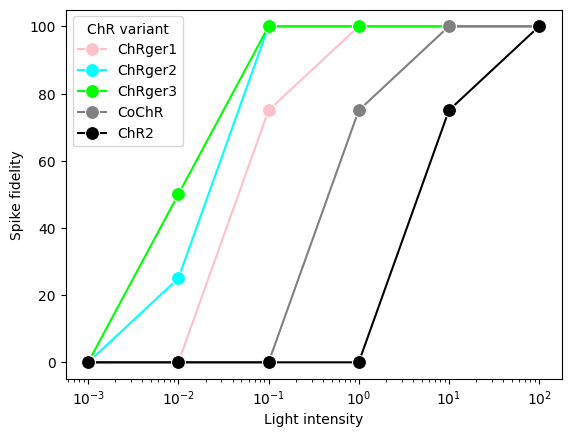

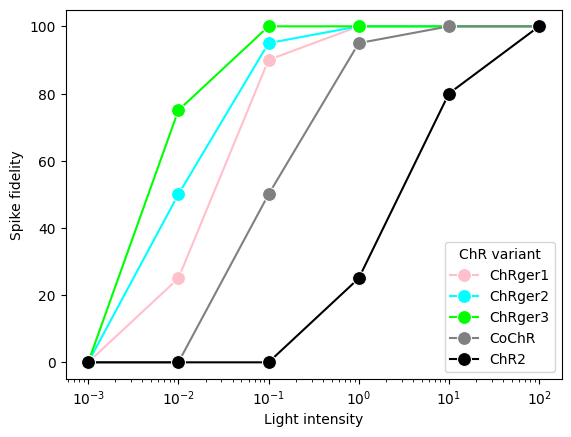

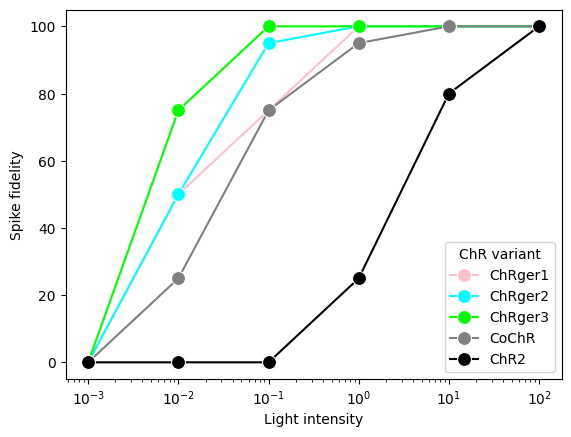

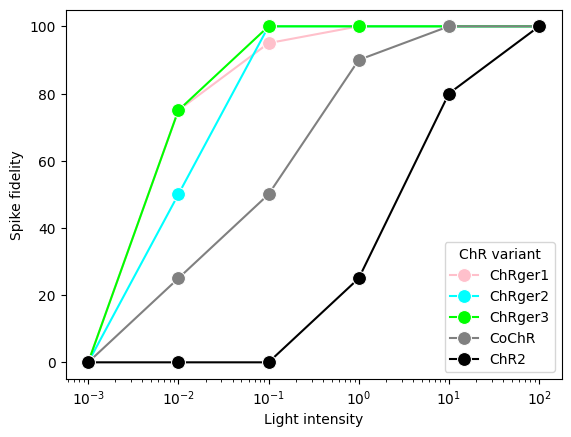

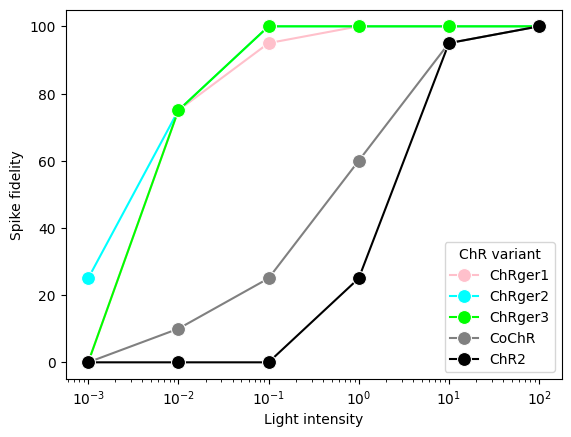

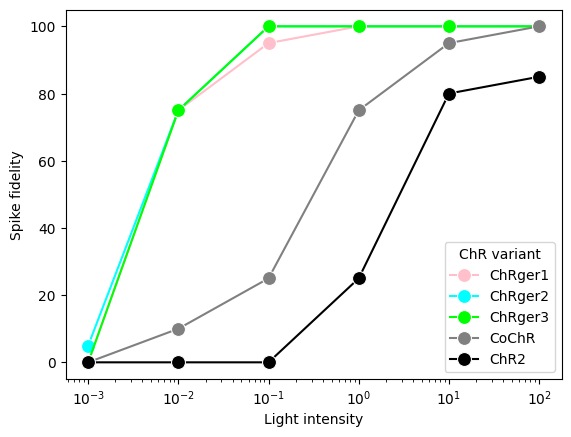

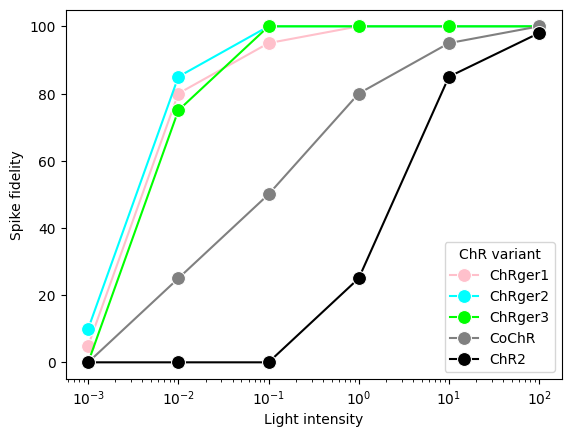

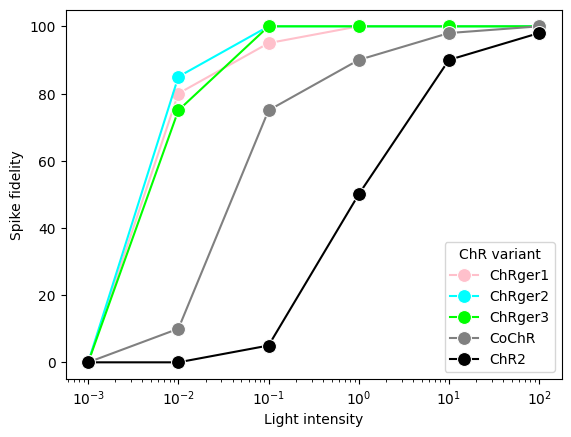

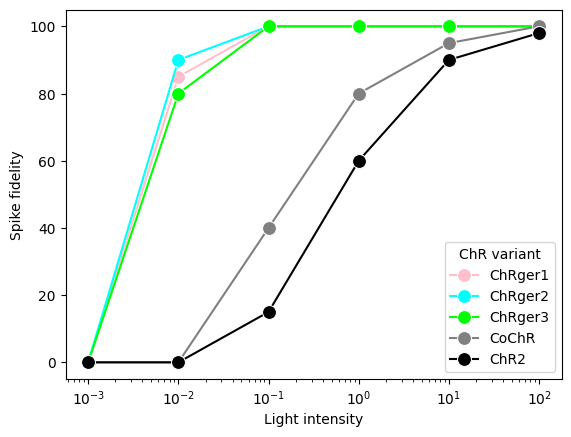

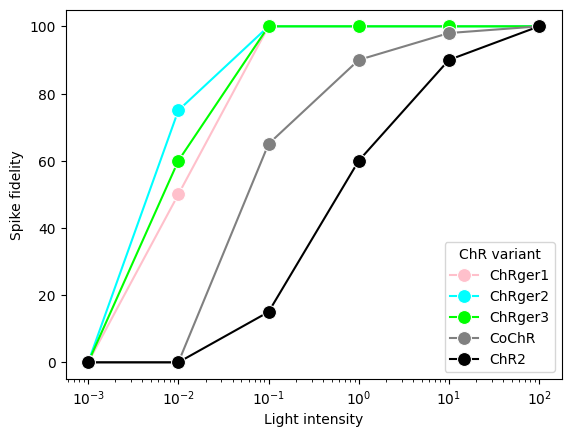

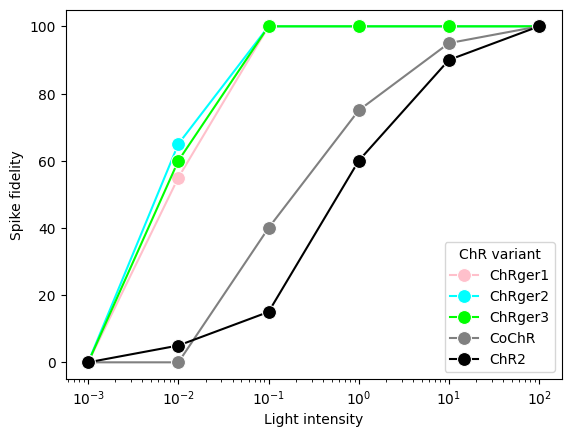

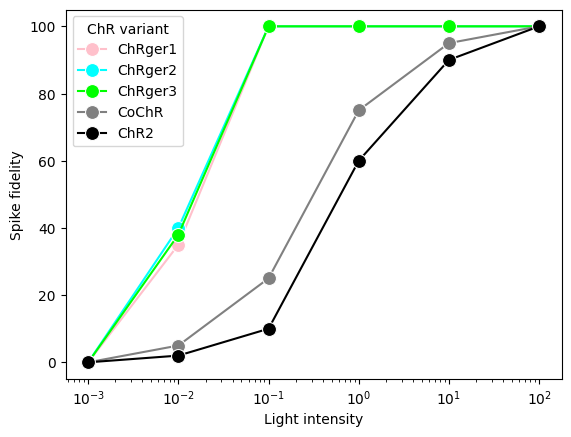

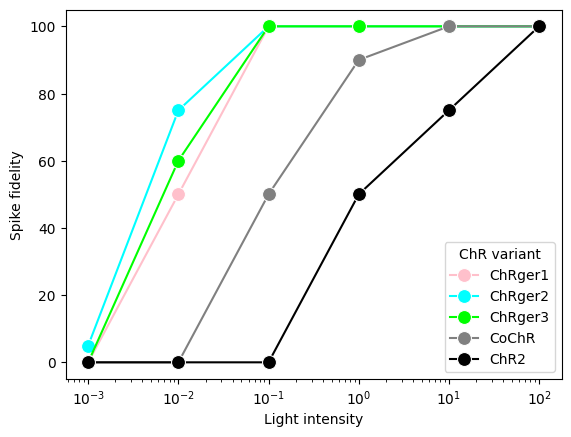

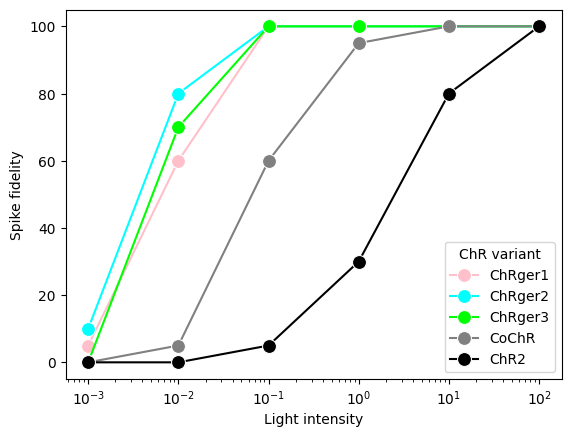

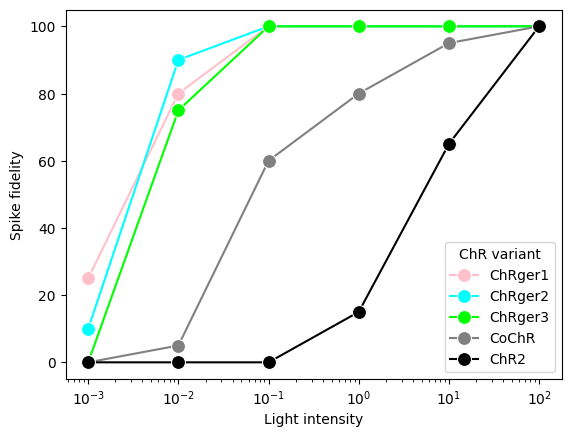

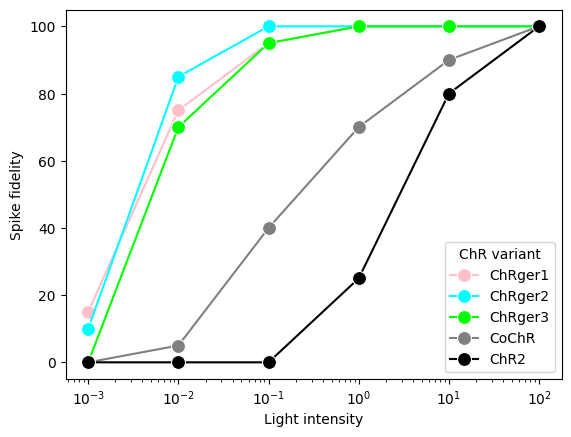

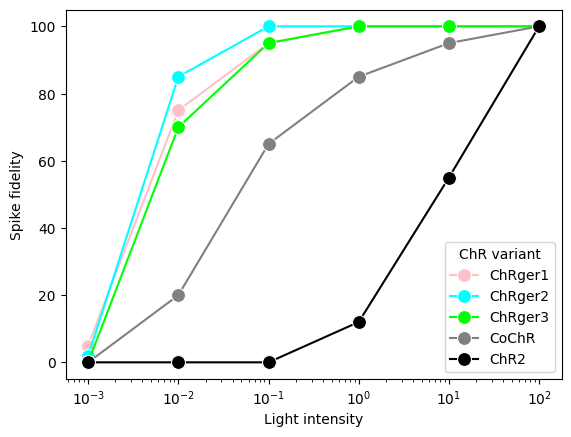

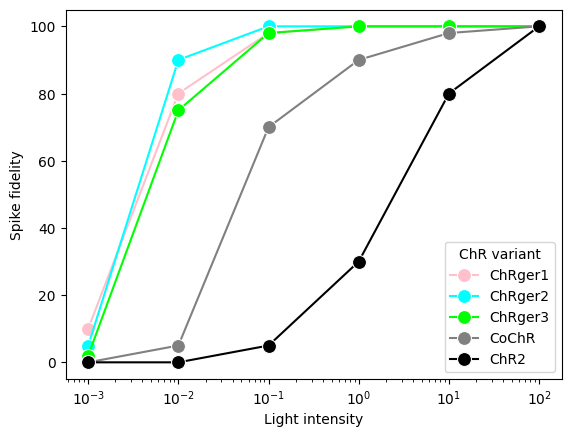

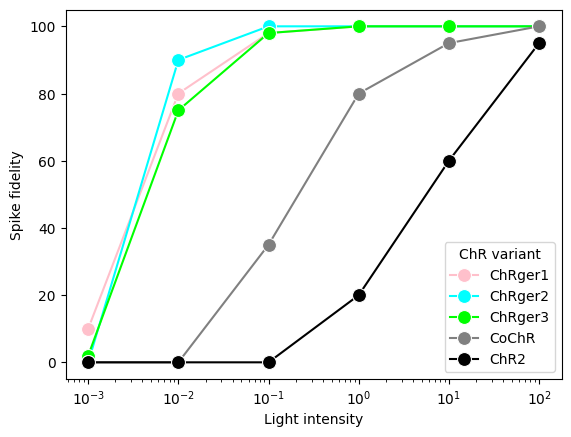

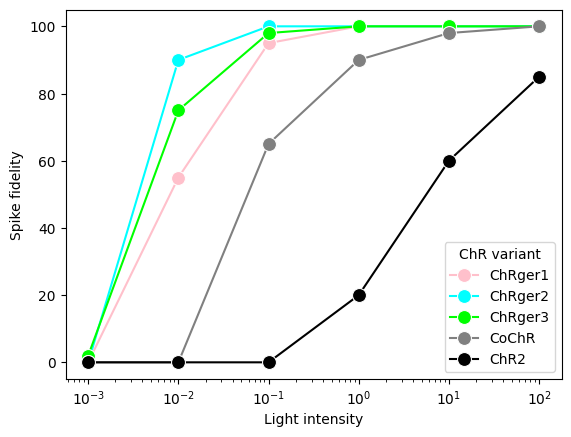

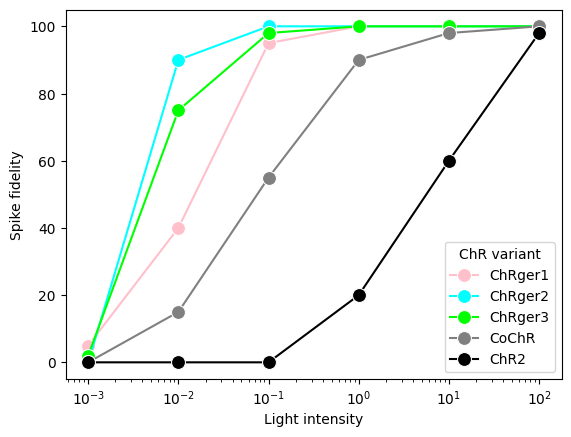

In [59]:
from matplotlib import pyplot as plt
from PIL import Image

chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items()]
palette = [np.array(v)/255. for k,v in chr_variant_iv.values.items()]

fig, axes = plt.subplots()
sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette,
    ax=axes
)
axes.set_xscale('log')

# get plot as PIL Image
fig.savefig('plot_0.png')

generated_img_loop = Image.open('plot_0.png')
panel_df_loop = panel_df

for iter in range(20):




    claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620", temperature=0.5)


    prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three largest quantitative differences between the re-plotted data and the data in the source figure.
If possible, prioritize general differences that affect many datapoints over adjustments to individual datapoints.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df_loop.to_markdown()}
    """


    response__loop = claude_mm.message(prompt, images = [source_figure, generated_img_loop])

    feedback_loop = response__loop.content[0].text
    print(feedback_loop)

    output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


    columns = {iv.name: pd.Series() for iv in exp.independent_variables}
    dep_var = exp.dependent_variables[0]
    columns.update({dep_var.name: pd.Series()})
    df = pd.DataFrame(columns)

    prompt_base = """
You were previously given the following task:
"In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?"

Here is you the dataframe output from your previous response:
{df_table}

We have reviewed your response and notice these important changes that will improve the match to the source figure:
{feedback}

Please revise your response by incorporating these changes. 
Adjust the values in the dataframe in the most parsimonious way possible to match the source figure.
This could mean scaling or shift all or a subset of the rows and/or columns.
Please let any specific changes inform your overall response if that is necessary to match the source figure.

And remember, our goal is to match the data points in the plot EXACTLY - not just the shapes or trends.

Return your data using the following column schema: {schema}.
    """.format(
        fig_num = fig_num,
        panel_name = panel.name, 
        # dep_var_stat = dep_var.statistics[0],
        plot_name = plot.name,
        dep_var_name = dep_var.name,
        ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
        schema = ", ".join(df.columns),
        feedback = feedback_loop,
        df_table = panel_df_loop.to_markdown(),
    ).replace("{","<").replace("}",">")

    prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    data_response_loop = query_tool(prompt)
    panel_df_loop = output_parser.parse(data_response_loop.content).to_df(existing_df=df)

    # Create a new figure and axes
    fig, axes = plt.subplots()
    
    # Plot the line plot on the new axes
    # sns.lineplot(
    #     data=panel_df_loop,
    #     x='Light intensity',
    #     y='Spike fidelity',
    #     hue='ChR variant',
    #     marker='o',
    #     # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    #     markersize=10,
    #     ax=axes
    # )
    sns.lineplot(
        data=panel_df_loop,
        x='Light intensity',
        y='Spike fidelity',
        hue='ChR variant',
        marker='o',
        hue_order=chr_variant_order,
        markersize=10,
        palette=palette,
        ax=axes
    )
    axes.set_xscale('log')

    fig.savefig(f'plot_{iter+1}.png')
    generated_img_loop = Image.open(f'plot_{iter+1}.png')

In [401]:
print(prompt)


    YOUR OVERALL JOB:
        You were previously given the following task:

            In Figure 2d, plot Spike fidelity vs Light intensity, what are the values for the dependent variable Spike fidelity?
            And you were asked to return you data in a DataFrame and were provided with information about the independent variables and their values for this plot.

        Here is you the dataframe output from your previous response:
        |    |   Light intensity | ChR variant   |   Spike fidelity |
|---:|------------------:|:--------------|-----------------:|
|  0 |             0.001 | ChRger1       |                0 |
|  1 |             0.003 | ChRger1       |                0 |
|  2 |             0.01  | ChRger1       |               10 |
|  3 |             0.03  | ChRger1       |               40 |
|  4 |             0.06  | ChRger1       |               80 |
|  5 |             0.1   | ChRger1       |               95 |
|  6 |             0.3   | ChRger1       |            

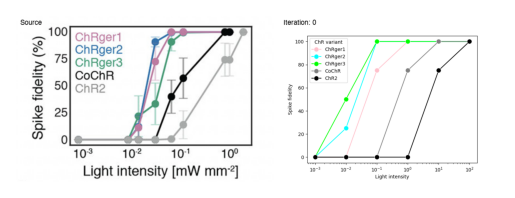

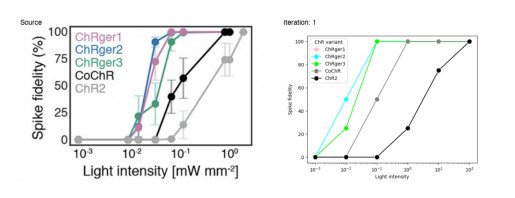

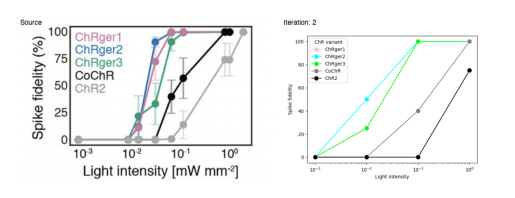

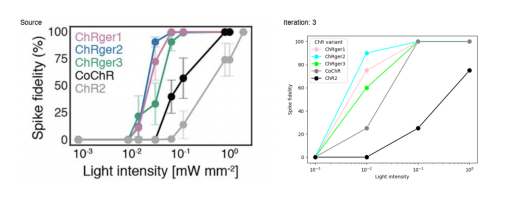

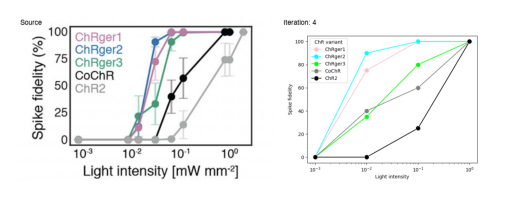

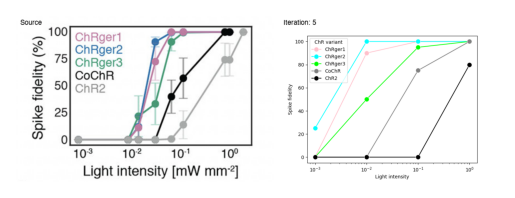

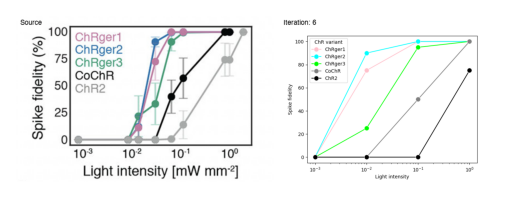

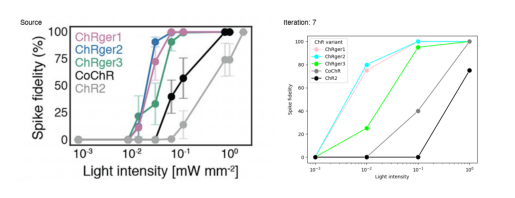

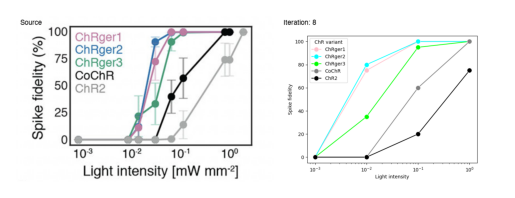

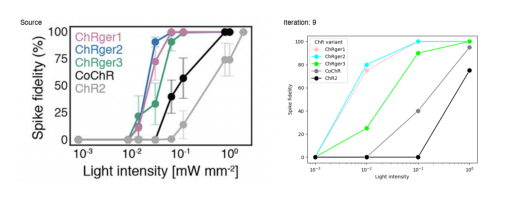

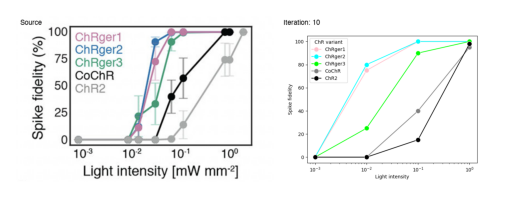

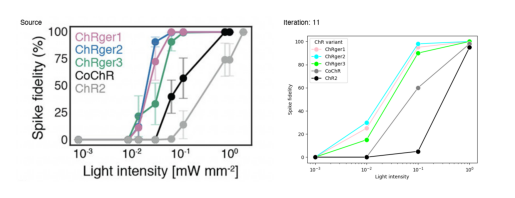

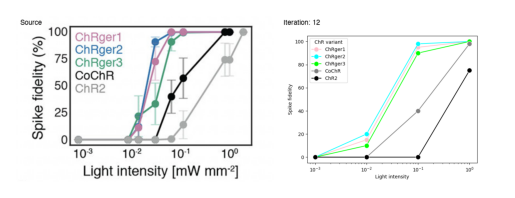

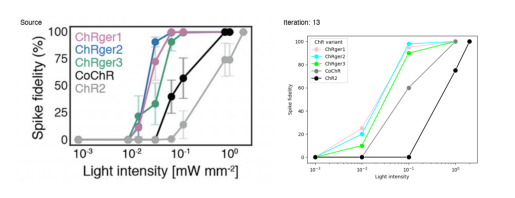

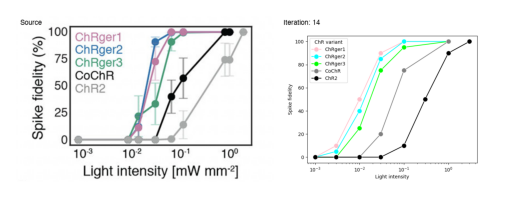

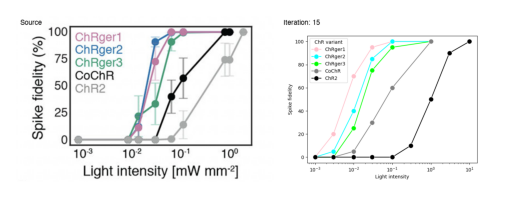

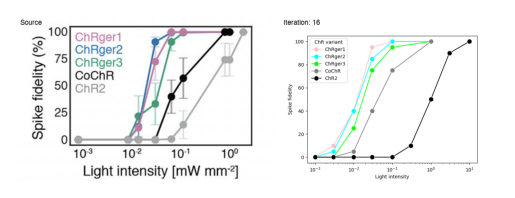

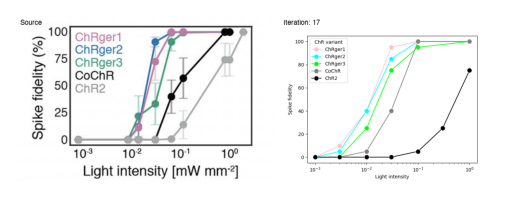

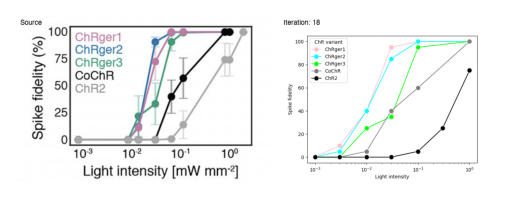

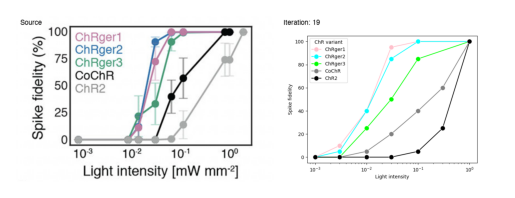

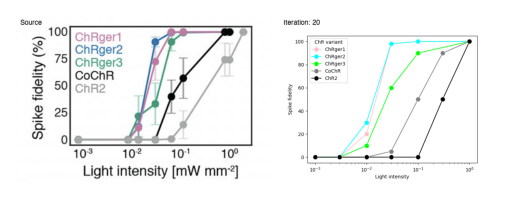

MP4 video saved as 'comparison.mp4'


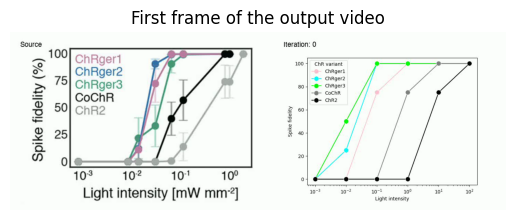

In [58]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
generated_fig_panel_path_base = "/Users/loyalshababo/dev/plotreader/sandbox/plot_{iter}.png"

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np

def create_side_by_side_image(source_img, generated_img, iter_number):
    # Resize both images to have the same height
    target_height = 480  # You can adjust this value as needed
    source_img_resized = source_img.resize((int(source_img.width * target_height / source_img.height), target_height))
    generated_img_resized = generated_img.resize((int(generated_img.width * target_height / generated_img.height), target_height))
    
    # Create a new image with the width of both resized images and the target height, plus padding
    padding = 20  # Adjust padding as needed
    total_width = source_img_resized.width + generated_img_resized.width + (3 * padding)  # Extra padding between images
    total_height = target_height + (2 * padding)
    combined_img = Image.new('RGB', (total_width, total_height), color='white')
    
    # Paste the resized source image on the left
    combined_img.paste(source_img_resized, (padding, padding))
    
    # Paste the resized generated image on the right
    combined_img.paste(generated_img_resized, (source_img_resized.width + (2 * padding), padding))
    
    # Add titles to the images
    draw = ImageDraw.Draw(combined_img)
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    
    # Add "Source" title
    draw.text((padding + 10, padding + 10), "Source", fill="black", font=font)
    
    # Add "Iteration: iter_number" title
    draw.text((source_img_resized.width + (2 * padding) + 10, padding + 10), f"Iteration: {iter_number}", fill="black", font=font)
    
    return combined_img

# Load the source panel image
source_img = Image.open(source_panel)

# Create a list to store the frames
frames = []

# Generate frames for each iteration
for iter in range(21):  # 0 to 10
    generated_img_path = generated_fig_panel_path_base.format(iter=iter)
    try:
        generated_img = Image.open(generated_img_path)
        
        # Create the side-by-side image with titles
        combined_img = create_side_by_side_image(source_img, generated_img, iter)
        
        # Convert PIL Image to numpy array
        frame = cv2.cvtColor(np.array(combined_img), cv2.COLOR_RGB2BGR)
        
        # Append the combined image to frames
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: Image file not found for iteration {iter}")

# Check if we have any frames
if not frames:
    print("No frames were generated. Check if the image files exist.")
else:
    # Define the output video file
    output_file = 'comparison.mp4'

    # Get the frame size
    height, width, layers = frames[0].shape

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 1.0, (width, height))  # 2.0 fps for 5 seconds total with 10 frames

    # Write frames to video
    for frame in frames:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        out.write(frame)

    # Release the VideoWriter
    out.release()

    print(f"MP4 video saved as '{output_file}'")

# Verify the output video
cap = cv2.VideoCapture(output_file)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame of the output video")
        plt.show()
    else:
        print("Failed to read the first frame")
    cap.release()
else:
    print("Failed to open the output video file")


/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_39940/1437840151.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


[]

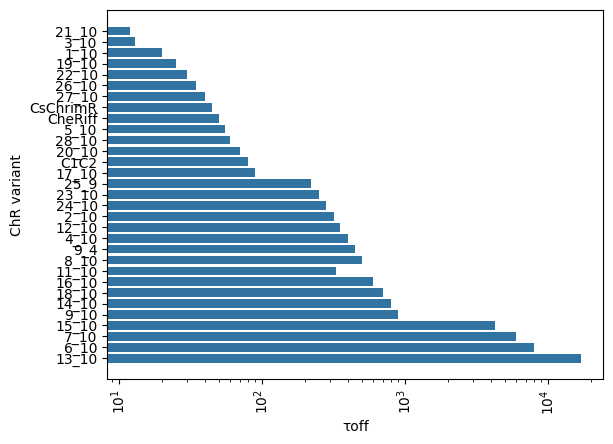

In [27]:
# panel_df_adjusted = panel_df.copy()
# panel_df_adjusted['τoff'] *= 1000

# horizontal bar plot
axes = sns.barplot(
    data=panel_df,
    x='τoff',
    y='ChR variant',
    orient='h',
)
# axes = sns.barplot(
#     data=panel_df,
#     x='ChR variant',
#     y='τoff',
# )
# rotate x-tick labels 90 deg
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.semilogx()



<Axes: xlabel='Wavelength', ylabel='Normalized photocurrent'>

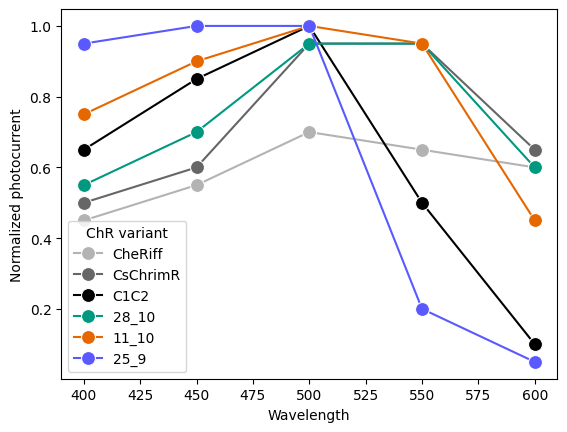

In [127]:
palette = [v for k,v in chr_variant_iv.values.items()]

sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
    palette=[[0.7, 0.7, 0.7], [0.4, 0.4, 0.4], [0, 0, 0], [0, .6 , .5], [0.9, 0.4, 0.0], [0.35, 0.35, 1.0]]
)
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [23]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [40]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import MetadataMode

In [42]:
for node in retrieverd_nodes[:-1]:
    try:
        display_source_node(node, source_length=100000)
    except:
        print(node)

**Node ID:** 7cf5ee59-0e97-445f-8884-f4e21f7bba21<br>**Similarity:** 0.40960259534169907<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents. (continued)<br>

**Node ID:** 5cb68f1f-e64c-4502-9da2-c42717a765e2<br>**Similarity:** 0.4057491962557034<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.<br>

**Node ID:** d04f54e0-29ba-4046-92a6-7d2c6e9268f0<br>**Similarity:** 0.3793601396922902<br>**Text:** Figure 2 shows that the model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.

Section a shows representative current traces after 0.5 s light exposure for select designer ChR variants with corresponding expression and localization in HEK cells. Vertical scale bar for each ChR current trace represents 1 nA, and horizontal scale bar represents 250 ms. The variant color presented in (a) is constant throughout panels. CheRiff, C1C2 are represented in gray, CsChrimR in black, 11_10 in cyan, 12_10 in magenta, 25_9 in light blue, 10_10 in yellow, 15_10 in blue, 28_10 in orange, 21_10 in purple, and 3_10 in red. The bottom row shows fluorescence images of ChR expression in HEK cells, with a 20 μm scale bar.

Section b displays measured peak and steady-state photocurrent with different wavelengths of light in HEK cells (n=4-8 cells, see Dataset 2). Four wavelengths are shown: 397 nm, 481 nm, 546 nm, and 640 nm. The y-axis shows photocurrent in pA, with different scales for each wavelength. Peak currents are represented by dark gray bars, while steady-state currents are in light gray. Error bars are included.

Section c shows off-kinetics decay rate (τoff) following a 1 ms exposure to 481 nm light at 2.3 mW mm^2 (n=4-8 cells, see Dataset 2). Parent ChRs are highlighted in light gray. The x-axis shows τoff values on a logarithmic scale from 10^1 to 10^4 ms. Inset shows representative current traces with 1 ms light exposure for select ChRs revealing distinct profiles: ChR_21_10 (purple) turns off rapidly, ChR_3_10 (red) and ChR_25_9 (light blue) turn off more slowly, and ChR_15_10 (blue) exhibits little decrease in photocurrent 0.5 s after the light exposure. The time scale for these traces is 100 ms.

Section d shows normalized photocurrent as a function of wavelength for various ChR variants. The wavelengths range from 400 nm to 600 nm. Different colored lines represent different ChR variants, corresponding to the colors in panel a.

Section e displays peak photocurrent (left) and steady-state photocurrent (right) as a function of light intensity for various ChR variants. The x-axis shows light intensity from 10^-1 to 10^1 mW mm^-2 on a logarithmic scale. The y-axis shows photocurrent in pA, up to 2500 pA. Different colored lines represent different ChR variants, corresponding to the colors in panel a. Error bars are included.<br>**Image:**

**Node ID:** 22d9ee84-5d29-4f92-8527-e0ae97939355<br>**Similarity:** 0.36910398090655805<br>**Text:** Selection of designer ChRs using trained models<br>

**Node ID:** 5bbfd688-9a2b-439b-a86b-c786e9c193e7<br>**Similarity:** 0.35990217183769474<br>**Text:** Light delivery and imaging<br>

In [47]:
index_node = node.node

In [49]:
index_node.

'Light delivery and imaging'